# Training Model Bi-LSTM

## Import Library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
print(tf.__version__)

2.15.0


## Set Parameter

In [3]:
BATCH_SIZE = 64  # Number of examples used in each iteration
EPOCHS = 50  # Number of passes through entire dataset
MAX_LEN = 200  # Max length of review (in words)
EMBEDDING = 100  # Dimension of word embedding vector

## Load Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("..\Data\Dataset-500PidanaFix.csv", encoding="latin1")

data['word'] = data['word'].replace(to_replace ='\d+', value = '<\g<0>>', regex = True)
data = data.fillna(method="ffill")

In [5]:
data

,doc,sentence,word,prev,next,tag
0,doc:0,sentence: 000001,putusan,.,nomor,O
1,doc:0,sentence: 000001,nomor,putusan,48,O
2,doc:0,sentence: 000001,<48>,nomor,/,B_VERN
3,doc:0,sentence: 000001,/,48,pid,I_VERN
4,doc:0,sentence: 000001,pid,/,.,I_VERN
...,...,...,...,...,...,...
4082187,doc:601,sentence: 078262,panitera,.,pengganti,O
4082188,doc:601,sentence: 078262,pengganti,panitera,",",O
4082189,doc:601,sentence: 078262,",",pengganti,ttd,O
4082190,doc:601,sentence: 078262,ttd,",",suraji,O


In [6]:
data.groupby('tag').count()

,doc,sentence,word,prev,next
tag,,,,,
B_ARTV,1509,1509,1509,1509,1509
B_CRIA,2625,2625,2625,2625,2625
B_DEFN,10914,10914,10914,10914,10914
B_JUDP,1195,1195,1195,1195,1195
B_JUG,2243,2243,2243,2243,2243
B_PENA,603,603,603,603,603
B_PROS,549,549,549,549,549
B_PUNI,755,755,755,755,755
B_REGI,1138,1138,1138,1138,1138


### Menghapus Sentence dengan tag O yang dominan

In [7]:
data['tag'] = data['tag'].apply(lambda x: [x])
# Gabungkan tags dalam sentence yang sama dan hapus sentence yang hanya berisi tag 'O'
df_combined = (
    data.groupby(['doc', 'sentence'])['tag']
    .agg(lambda x: sum(x, []))
    .apply(lambda tags: tags if any(tag != 'O' for tag in tags) else [])
    .reset_index(name='tag')
)

# Hapus baris yang tidak memiliki tag atau memiliki tag kosong
df_combined = df_combined[df_combined['tag'].apply(lambda x: bool(x))]

# Buat DataFrame baru hanya berisi baris yang sesuai dengan df_combined
filtered_df = data[data['sentence'].isin(df_combined['sentence'])]

# Pisahkan df_combined per tag dan isi sentence berdasarkan tag yang dipisah tadi
result_rows = []
for index, row in filtered_df.iterrows():
    for tag in row['tag']:
        result_rows.append({
            'doc': row['doc'],
            'sentence': row['sentence'],
            'word': row['word'],
            'prev': row['prev'],
            'next': row['next'],
            'tag': tag
        })

# Tampilkan dataframe setelah penggabungan, penghapusan, pemisahan kembali tags, dan pengisian kolom 'sentence'
data = pd.DataFrame(result_rows)

# Tampilkan dataframe hasil
data

,doc,sentence,word,prev,next,tag
0,doc:0,sentence: 000001,putusan,.,nomor,O
1,doc:0,sentence: 000001,nomor,putusan,48,O
2,doc:0,sentence: 000001,<48>,nomor,/,B_VERN
3,doc:0,sentence: 000001,/,48,pid,I_VERN
4,doc:0,sentence: 000001,pid,/,.,I_VERN
...,...,...,...,...,...,...
1257467,doc:601,sentence: 078262,panitera,.,pengganti,O
1257468,doc:601,sentence: 078262,pengganti,panitera,",",O
1257469,doc:601,sentence: 078262,",",pengganti,ttd,O
1257470,doc:601,sentence: 078262,ttd,",",suraji,O


In [8]:
data.groupby('tag').count()

,doc,sentence,word,prev,next
tag,,,,,
B_ARTV,1509,1509,1509,1509,1509
B_CRIA,2625,2625,2625,2625,2625
B_DEFN,10914,10914,10914,10914,10914
B_JUDP,1195,1195,1195,1195,1195
B_JUG,2243,2243,2243,2243,2243
B_PENA,603,603,603,603,603
B_PROS,549,549,549,549,549
B_PUNI,755,755,755,755,755
B_REGI,1138,1138,1138,1138,1138


In [9]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
n_words

23157

In [10]:
tags = sorted(list(set(data["tag"])))
n_tags = len(tags)
n_tags

23

### Mengelompokan Dataset per Sentence

In [11]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(data)
sentences = getter.sentences

## Word Embedding CBOW

In [13]:
from gensim.models import Word2Vec

In [14]:
# sentences_words = [[w[0] for w in s] for s in sentences]
# cbow_model = Word2Vec(sentences_words, vector_size=10, window=5, min_count=1, sg=0, seed=42)
# cbow_model.save("Model_CBOW\CBOWModel.model")

Load Model CBOW

In [15]:
cbow_model = Word2Vec.load("Model_CBOW\CBOWModel.model")

In [16]:
tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {i: w for w, i in tag2idx.items()}

In [17]:
def get_word_embedding(word):
    if word in cbow_model.wv:
        return cbow_model.wv[word]
    else:
        return np.zeros(cbow_model.vector_size)

In [18]:
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
X = [[get_word_embedding(w[0]) for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

## Spliting Data

In [19]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, shuffle=False,random_state=42)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((9133, 200, 10), (2284, 200, 10), (9133, 200, 24), (2284, 200, 24))

## Modeling

## Skenario I (SGD)

In [20]:
# from keras import Model
# from keras import optimizers
# from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D, Reshape
# from keras.initializers import glorot_uniform
# from keras.utils import plot_model

# input = Input(shape=(MAX_LEN, cbow_model.vector_size))

# modelSGD = Dropout(0.1)(input)
# modelSGD = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(modelSGD)

# out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(modelSGD)  # softmax output layer

# modelSGD = Model(input, out)

# modelSGD.compile("sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# modelSGD.summary()

## Visualisasi Model

In [21]:
# ! pip install pydot graphviz

In [22]:
# from keras.utils import plot_model

# plot_model(modelSGD, to_file='model_visualizationSGD.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image

# image_path = 'model_visualizationSGD.png'
# display(Image(filename=image_path))
# with open(image_path, 'rb') as img_file:
#     img_data = img_file.read()

### Training Model Bi-LSTM (SGD)

In [23]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# import time

# class WeightsLogger(Callback):
#     def __init__(self):
#         super(WeightsLogger, self).__init__()
#         self.logs = []  # List to store weights and epochs

#     def on_epoch_end(self, epoch, logs=None):
#         weights = self.model.get_weights()
#         self.logs.append({
#             'epoch': epoch + 1,
#             'weights': weights
#         })

#     def on_train_end(self, logs=None):
#         # Save weights logs to CSV file
#         df = pd.DataFrame(self.logs)
#         df.to_csv('Hasil Training\ModelSGD\Bobot.csv', index=False)

# class MetricsLogger(Callback):
#     def __init__(self):
#         super(MetricsLogger, self).__init__()
#         self.logs = []

#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_start_time = time.time()

#     def on_epoch_end(self, epoch, logs=None):
#         elapsed_time = time.time() - self.epoch_start_time
#         elapsed_time_rounded = round(elapsed_time)  # Round to nearest second
#         log_entry = {
#             'epoch': epoch + 1,
#             'accuracy': logs.get('accuracy'),
#             'val_accuracy': logs.get('val_accuracy'),
#             'loss': logs.get('loss'),
#             'val_loss': logs.get('val_loss'),
#             'time': elapsed_time_rounded
#         }
#         self.logs.append(log_entry)

#     def on_train_end(self, logs=None):
#         df = pd.DataFrame(self.logs)
#         df = df[['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss', 'time']]
#         df.to_csv('Hasil Training/training_metricsSGD.csv', index=False)

# checkpoint = ModelCheckpoint(
#     filepath='Hasil Training\ModelSGD\modelSGD_epoch_{epoch:02d}.keras',  # Filepath to save model, including epoch number
#     save_weights_only=False,                # Save the whole model, not just weights
#     save_freq='epoch',                      # Save the model at the end of every epoch
#     save_best_only=False                    # Save model every epoch, not just the best one
# )
# weights_logger = WeightsLogger()
# metrics_logger = MetricsLogger()
# historySGD = modelSGD.fit(np.array(X_tr).astype(int),
#                     np.array(y_tr).astype(int),
#                     batch_size=BATCH_SIZE,
#                     epochs=50,
#                     validation_split=0.1,
#                     verbose=1,
#                     shuffle=False,
#                     callbacks=[weights_logger,metrics_logger,checkpoint])

### Save Model

In [24]:
# pathSGD = 'Hasil Training\ModelSGD.keras'
# modelSGD.save(pathSGD)
# modelSGD.save_weights('Hasil Training\modelSGD.weights.h5')

### Load Model

In [25]:
from tensorflow.keras.models import load_model
save_pathSGD = 'Hasil Training\ModelSGD.keras'
modelSGD = load_model(save_pathSGD)
modelSGD.load_weights('Hasil Training\modelSGD.weights.h5')

### Grafik Akurasi dan Loss

In [26]:
# acc = historySGD.history['accuracy']
# val_acc = historySGD.history['val_accuracy']

# loss = historySGD.history['loss']
# val_loss = historySGD.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

## Skenario II (Adam)

In [27]:
# from keras import Model
# from keras import optimizers
# from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D, Reshape
# from keras.initializers import glorot_uniform
# from keras.utils import plot_model
# SEED = 42

# # input = Input(shape=(MAX_LEN,)) #Asli
# input = Input(shape=(MAX_LEN, cbow_model.vector_size))

# # model = Embedding(input_dim=n_words, output_dim=10, input_length=5)(input)
# modelAdam = Dropout(0.1)(input)
# modelAdam = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(modelAdam)

# out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(modelAdam)  # softmax output layer

# modelAdam = Model(input, out)

# modelAdam.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# modelAdam.summary()

In [28]:
# from keras.utils import plot_model

# plot_model(modelAdam, to_file='model_visualizationAdam.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image

# image_path = 'model_visualizationAdam.png'
# display(Image(filename=image_path))
# with open(image_path, 'rb') as img_file:
#     img_data = img_file.read()

### Training Model Bi-LSTM (Adam)

In [29]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# class WeightsLogger(Callback):
#     def __init__(self):
#         super(WeightsLogger, self).__init__()
#         self.logs = []  # List to store weights and epochs

#     def on_epoch_end(self, epoch, logs=None):
#         weights = self.model.get_weights()
#         self.logs.append({
#             'epoch': epoch + 1,
#             'weights': weights
#         })

#     def on_train_end(self, logs=None):
#         # Save weights logs to CSV file
#         df = pd.DataFrame(self.logs)
#         df.to_csv('Hasil Training\ModelAdam\Bobot.csv', index=False)

# class MetricsLogger(Callback):
#     def __init__(self):
#         super(MetricsLogger, self).__init__()
#         self.logs = []

#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_start_time = time.time()

#     def on_epoch_end(self, epoch, logs=None):
#         elapsed_time = time.time() - self.epoch_start_time
#         elapsed_time_rounded = round(elapsed_time)  # Round to nearest second
#         log_entry = {
#             'epoch': epoch + 1,
#             'accuracy': logs.get('accuracy'),
#             'val_accuracy': logs.get('val_accuracy'),
#             'loss': logs.get('loss'),
#             'val_loss': logs.get('val_loss'),
#             'time': elapsed_time_rounded
#         }
#         self.logs.append(log_entry)

#     def on_train_end(self, logs=None):
#         df = pd.DataFrame(self.logs)
#         df = df[['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss', 'time']]
#         df.to_csv('Hasil Training/training_metricsAdam.csv', index=False)

# checkpoint = ModelCheckpoint(
#     filepath='Hasil Training\ModelAdam\modelAdam_epoch_{epoch:02d}.keras',  # Filepath to save model, including epoch number
#     save_weights_only=False,                # Save the whole model, not just weights
#     save_freq='epoch',                      # Save the model at the end of every epoch
#     save_best_only=False                    # Save model every epoch, not just the best one
# )
# weights_logger = WeightsLogger()
# metrics_logger = MetricsLogger()
# historyAdam = modelAdam.fit(np.array(X_tr).astype(int),
#                     np.array(y_tr).astype(int),
#                     batch_size=BATCH_SIZE,
#                     epochs=50,
#                     validation_split=0.1,
#                     verbose=1,
#                     shuffle=False,
#                     callbacks=[weights_logger,metrics_logger,checkpoint])

### Save Model

In [30]:
# pathAdam = 'Hasil Training\modelAdam.keras'
# modelAdam.save(pathAdam)
# modelAdam.save_weights('Hasil Training\modelAdam.weights.h5')

### Load Model

In [41]:
from tensorflow.keras.models import load_model
save_pathAdam = 'Hasil Training\modelAdam.keras'
modelAdam = load_model(save_pathAdam)
modelAdam.load_weights('Hasil Training\modelAdam.weights.h5')

### Grafik Akurasi dan Loss

In [32]:
# acc = historyAdam.history['accuracy']
# val_acc = historyAdam.history['val_accuracy']

# loss = historyAdam.history['loss']
# val_loss = historyAdam.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

## Skenario III (Rmsprop)

In [33]:
# from keras import Model
# from keras import optimizers
# from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D, Reshape
# from keras.initializers import glorot_uniform
# from keras.utils import plot_model

# input = Input(shape=(MAX_LEN, cbow_model.vector_size))

# modelRmsprop = Dropout(0.1)(input)
# modelRmsprop = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(modelRmsprop)

# out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(modelRmsprop)  # softmax output layer

# modelRmsprop = Model(input, out)

# modelRmsprop.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# modelRmsprop.summary()

In [34]:
# from keras.utils import plot_model

# plot_model(modelRmsprop, to_file='model_visualizationRmsprop.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image

# image_path = 'Visualisasi Model\model_visualizationRmsprop.png'
# display(Image(filename=image_path))
# with open(image_path, 'rb') as img_file:
#     img_data = img_file.read()

### Training Model Bi-LSTM (Rmsprop)

In [35]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# import time

# class WeightsLogger(Callback):
#     def __init__(self):
#         super(WeightsLogger, self).__init__()
#         self.logs = []  # List to store weights and epochs

#     def on_epoch_end(self, epoch, logs=None):
#         weights = self.model.get_weights()
#         self.logs.append({
#             'epoch': epoch + 1,
#             'weights': weights
#         })

#     def on_train_end(self, logs=None):
#         # Save weights logs to CSV file
#         df = pd.DataFrame(self.logs)
#         df.to_csv('Hasil Training\ModelRmsprop\Bobot.csv', index=False)

# class MetricsLogger(Callback):
#     def __init__(self):
#         super(MetricsLogger, self).__init__()
#         self.logs = []

#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_start_time = time.time()

#     def on_epoch_end(self, epoch, logs=None):
#         elapsed_time = time.time() - self.epoch_start_time
#         elapsed_time_rounded = round(elapsed_time)  # Round to nearest second
#         log_entry = {
#             'epoch': epoch + 1,
#             'accuracy': logs.get('accuracy'),
#             'val_accuracy': logs.get('val_accuracy'),
#             'loss': logs.get('loss'),
#             'val_loss': logs.get('val_loss'),
#             'time': elapsed_time_rounded
#         }
#         self.logs.append(log_entry)

#     def on_train_end(self, logs=None):
#         df = pd.DataFrame(self.logs)
#         df = df[['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss', 'time']]
#         df.to_csv('Hasil Training/training_metricsRmsprop.csv', index=False)

# checkpoint = ModelCheckpoint(
#     filepath='Hasil Training\ModelRmsprop\modelRmsprop_epoch_{epoch:02d}.keras',  # Filepath to save model, including epoch number
#     save_weights_only=False,                # Save the whole model, not just weights
#     save_freq='epoch',                      # Save the model at the end of every epoch
#     save_best_only=False                    # Save model every epoch, not just the best one
# )
# Weights_Logger = WeightsLogger()
# metrics_logger = MetricsLogger()

# historyRmsprop = modelRmsprop.fit(np.array(X_tr).astype(int),
#                     np.array(y_tr).astype(int),
#                     batch_size=BATCH_SIZE,
#                     epochs=50,
#                     validation_split=0.1,
#                     verbose=1,
#                     shuffle=False,
#                     callbacks=[Weights_Logger,metrics_logger,checkpoint])

### Save Model

In [36]:
# pathRmsprop = 'Hasil Training\modelRmsprop.keras'
# modelRmsprop.save(pathRmsprop)
# modelRmsprop.save_weights('Hasil Training\modelRmsprop.weights.h5')

### Load Model

In [40]:
from tensorflow.keras.models import load_model
save_pathRmsprop = 'Hasil Training\modelRmsprop.keras'
modelRmsprop = load_model(save_pathRmsprop)
modelRmsprop.load_weights('Hasil Training\modelRmsprop.weights.h5')

### Grafik Akurasi dan Loss

In [38]:
# acc = historyRmsprop.history['accuracy']
# val_acc = historyRmsprop.history['val_accuracy']

# loss = historyRmsprop.history['loss']
# val_loss = historyRmsprop.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,0.2])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

## Evaluasi Model

In [42]:
eveSGD = modelSGD.predict(X_te)
eveAdam = modelAdam.predict(X_te)
eveRmsprop = modelRmsprop.predict(X_te)

72/72 [==============================] - 8s 92ms/step


In [43]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

def c_report(y_true, y_pred):
    # Menggabungkan elemen-elemen array menjadi satu list
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    # Menghitung macro average precision, recall, dan F1-score
    precision_macro = precision_score(y_true_flat, y_pred_flat, average="macro")
    recall_macro = recall_score(y_true_flat, y_pred_flat, average="macro")
    f1_macro = f1_score(y_true_flat, y_pred_flat, average="macro")

    # Mencetak metrik macro average
    print("Hasil evaluasi seluruh tag:")
    print("Precision Score (Macro): {:.2f}".format(precision_macro))
    print("Recall Score (Macro)   : {:.2f}".format(recall_macro))
    print("F1-score Score (Macro) : {:.2f}".format(f1_macro))

    # Menghasilkan laporan klasifikasi
    report = classification_report(y_true_flat, y_pred_flat)

    # Mencetak laporan klasifikasi
    print("\nLaporan Klasifikasi Setiap Tag:")
    print(report)

    return {
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "classification_report": report
    }

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Fungsi untuk membuat classification report dan mengubahnya menjadi gambar tabel
def Visualisasi_c_report(y_true, y_pred, filename='classification_reportSGD.png'):
    # Menggabungkan elemen-elemen array menjadi satu list
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    # Menghitung classification report
    report_dict = classification_report(y_true_flat, y_pred_flat, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Membulatkan nilai-nilai dalam report_dfSGD menjadi dua angka desimal
#     report_df = report_df.applymap(lambda x: round(x, 2))
    report_df = report_df.round(2)

    # Membuat gambar tabel
    fig, ax = plt.subplots(figsize=(10, 6))  # Ukuran gambar dapat disesuaikan
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=report_df.values, colLabels=report_df.columns, rowLabels=report_df.index, cellLoc='center', loc='center')

    # Mengatur gaya tabel
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    # Menyimpan gambar tabel ke file
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)

### Evaluasi SGD

In [45]:
y_test_trueSGD = np.argmax(y_te, -1)
y_predSGD = np.argmax(eveSGD, axis=-1)

# Convert the index to tag
y_test_trueSGD = [[idx2tag[i] for i in row] for row in y_test_trueSGD]
y_predSGD = [[idx2tag[i] for i in row] for row in y_predSGD]

Classification Report

In [46]:
hasil_evaluasiSGD = c_report(y_test_trueSGD, y_predSGD)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hasil evaluasi seluruh tag:
Precision Score (Macro): 0.15
Recall Score (Macro)   : 0.14
F1-score Score (Macro) : 0.14


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Laporan Klasifikasi Setiap Tag:
              precision    recall  f1-score   support

      B_ARTV       0.00      0.00      0.00       309
      B_CRIA       0.00      0.00      0.00       677
      B_DEFN       0.00      0.00      0.00      1564
      B_JUDP       0.00      0.00      0.00       244
       B_JUG       0.00      0.00      0.00       459
      B_PENA       0.00      0.00      0.00       113
      B_PROS       0.00      0.00      0.00       119
      B_PUNI       0.00      0.00      0.00       136
      B_REGI       0.00      0.00      0.00       229
      B_TIMV       0.00      0.00      0.00       129
      B_VERN       0.00      0.00      0.00       358
      I_ARTV       0.57      0.52      0.55      2908
      I_CRIA       0.00      0.00      0.00       804
      I_DEFN       0.58      0.34      0.43      5409
      I_JUDP       0.00      0.00      0.00       253
       I_JUG       0.00      0.00      0.00       782
      I_PENA       0.00      0.00      0.00     

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report_image_pathSGD = 'Classification Report\classification_report_SGD.png'
Visualisasi_c_report(y_test_trueSGD, y_predSGD, filename=report_image_pathSGD)

# Memeriksa apakah file gambar telah dibuat
import os
if os.path.exists(report_image_pathSGD):
    print(f'Gambar classification report berhasil disimpan: {report_image_pathSGD}')
else:
    print('Gagal menyimpan gambar classification report.')


Confusion Matrix

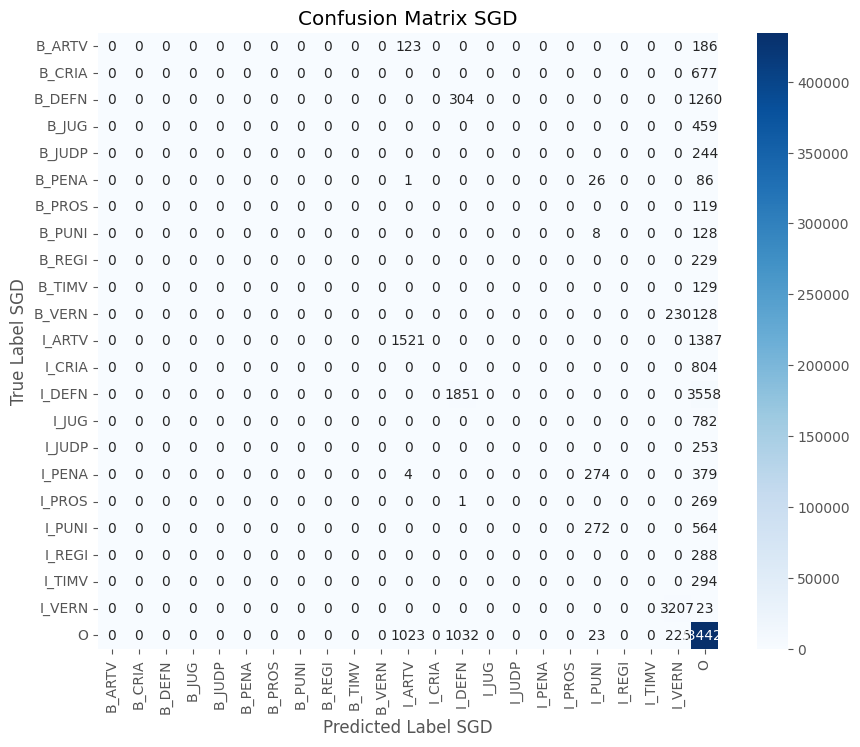

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Definisi class_names (sesuaikan dengan label yang sesuai dalam datasetmu)
class_names = ['B_ARTV', 'B_CRIA', 'B_DEFN', 'B_JUG', 'B_JUDP', 'B_PENA', 'B_PROS', 'B_PUNI', 'B_REGI', 'B_TIMV', 'B_VERN', 'I_ARTV', 'I_CRIA', 'I_DEFN', 'I_JUG', 'I_JUDP', 'I_PENA', 'I_PROS', 'I_PUNI', 'I_REGI', 'I_TIMV', 'I_VERN', 'O']

conf_matSGD = confusion_matrix([item for sublist in y_test_trueSGD for item in sublist],
                            [item for sublist in y_predSGD for item in sublist],
                            labels=class_names)
# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matSGD, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix SGD")
plt.xlabel("Predicted Label SGD")
plt.ylabel("True Label SGD")
plt.show()


### Evaluasi Adam

In [48]:
y_test_trueAdam = np.argmax(y_te, -1)
y_predAdam = np.argmax(eveAdam, axis=-1)

# Convert the index to tag
y_test_trueAdam = [[idx2tag[i] for i in row] for row in y_test_trueAdam]
y_predAdam = [[idx2tag[i] for i in row] for row in y_predAdam]

Classification Report

In [49]:
hasil_evaluasiAdam = c_report(y_test_trueAdam, y_predAdam)

Hasil evaluasi seluruh tag:
Precision Score (Macro): 0.88
Recall Score (Macro)   : 0.89
F1-score Score (Macro) : 0.88

Laporan Klasifikasi Setiap Tag:
              precision    recall  f1-score   support

      B_ARTV       0.88      0.79      0.84       309
      B_CRIA       0.88      0.79      0.83       677
      B_DEFN       0.76      0.79      0.77      1564
      B_JUDP       0.84      0.95      0.89       244
       B_JUG       0.84      0.98      0.91       459
      B_PENA       0.93      0.88      0.90       113
      B_PROS       0.94      0.96      0.95       119
      B_PUNI       0.84      0.88      0.86       136
      B_REGI       0.80      0.86      0.83       229
      B_TIMV       0.91      0.95      0.93       129
      B_VERN       0.96      1.00      0.98       358
      I_ARTV       0.81      0.87      0.84      2908
      I_CRIA       0.75      0.76      0.76       804
      I_DEFN       0.79      0.69      0.73      5409
      I_JUDP       0.93      0.85     

In [ ]:
report_image_pathAdam = 'Classification Report\classification_report_Adam.png'
Visualisasi_c_report(y_test_trueAdam, y_predAdam, filename=report_image_pathAdam)

# Memeriksa apakah file gambar telah dibuat
import os
if os.path.exists(report_image_pathAdam):
    print(f'Gambar classification report berhasil disimpan: {report_image_pathAdam}')
else:
    print('Gagal menyimpan gambar classification report.')

Confusion matrix

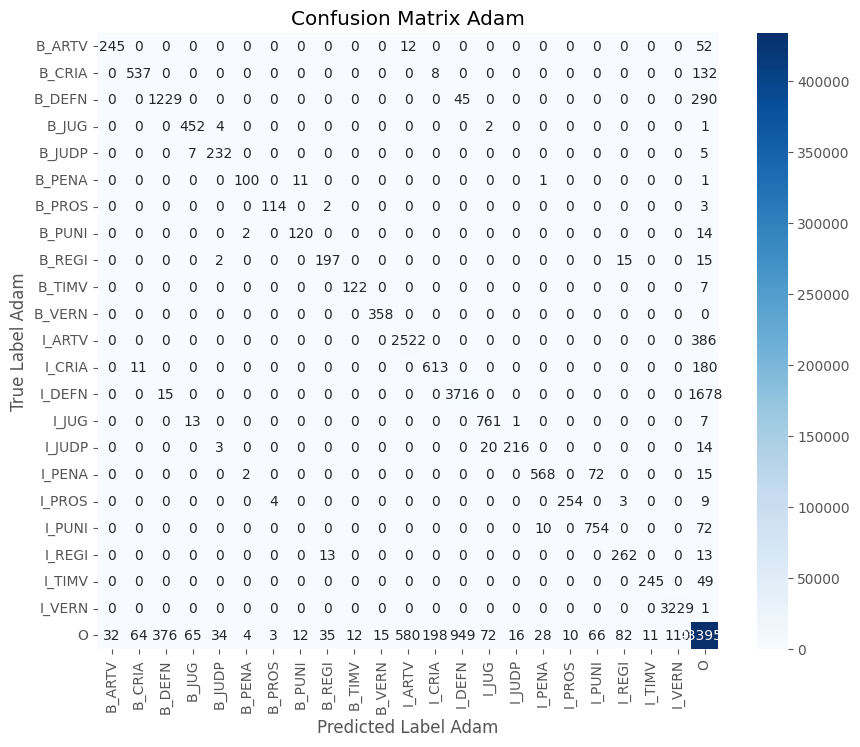

In [50]:
# Definisi class_names (sesuaikan dengan label yang sesuai dalam datasetmu)
class_names = ['B_ARTV', 'B_CRIA', 'B_DEFN', 'B_JUG', 'B_JUDP', 'B_PENA', 'B_PROS', 'B_PUNI', 'B_REGI', 'B_TIMV', 'B_VERN', 'I_ARTV', 'I_CRIA', 'I_DEFN', 'I_JUG', 'I_JUDP', 'I_PENA', 'I_PROS', 'I_PUNI', 'I_REGI', 'I_TIMV', 'I_VERN', 'O']

conf_matAdam = confusion_matrix([item for sublist in y_test_trueAdam for item in sublist],
                            [item for sublist in y_predAdam for item in sublist],
                            labels=class_names)
# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matAdam, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Adam")
plt.xlabel("Predicted Label Adam")
plt.ylabel("True Label Adam")
plt.show()


### Evaluasi Rmsprop

In [51]:
y_test_trueRmsprop = np.argmax(y_te, -1)
y_predRmsprop = np.argmax(eveRmsprop, axis=-1)

# Convert the index to tag
y_test_trueRmsprop = [[idx2tag[i] for i in row] for row in y_test_trueRmsprop]
y_predRmsprop = [[idx2tag[i] for i in row] for row in y_predRmsprop]

Classification Report

In [52]:
hasil_evaluasiRmsprop = c_report(y_test_trueRmsprop, y_predRmsprop)

Hasil evaluasi seluruh tag:
Precision Score (Macro): 0.88
Recall Score (Macro)   : 0.88
F1-score Score (Macro) : 0.88

Laporan Klasifikasi Setiap Tag:
              precision    recall  f1-score   support

      B_ARTV       0.83      0.82      0.82       309
      B_CRIA       0.87      0.68      0.76       677
      B_DEFN       0.66      0.82      0.73      1564
      B_JUDP       0.90      0.85      0.88       244
       B_JUG       0.82      0.98      0.89       459
      B_PENA       0.89      0.88      0.88       113
      B_PROS       0.98      0.99      0.98       119
      B_PUNI       0.88      0.88      0.88       136
      B_REGI       0.79      0.88      0.83       229
      B_TIMV       0.89      0.93      0.91       129
      B_VERN       0.95      1.00      0.98       358
      I_ARTV       0.81      0.89      0.85      2908
      I_CRIA       0.88      0.72      0.79       804
      I_DEFN       0.74      0.77      0.76      5409
      I_JUDP       0.95      0.68     

In [ ]:
report_image_pathRmsprop = 'Classification Report\classification_report_Rmsprop.png'
Visualisasi_c_report(y_test_trueRmsprop, y_predRmsprop, filename=report_image_pathRmsprop)

# Memeriksa apakah file gambar telah dibuat
import os
if os.path.exists(report_image_pathRmsprop):
    print(f'Gambar classification report berhasil disimpan: {report_image_pathRmsprop}')
else:
    print('Gagal menyimpan gambar classification report.')

Confusion Matrix

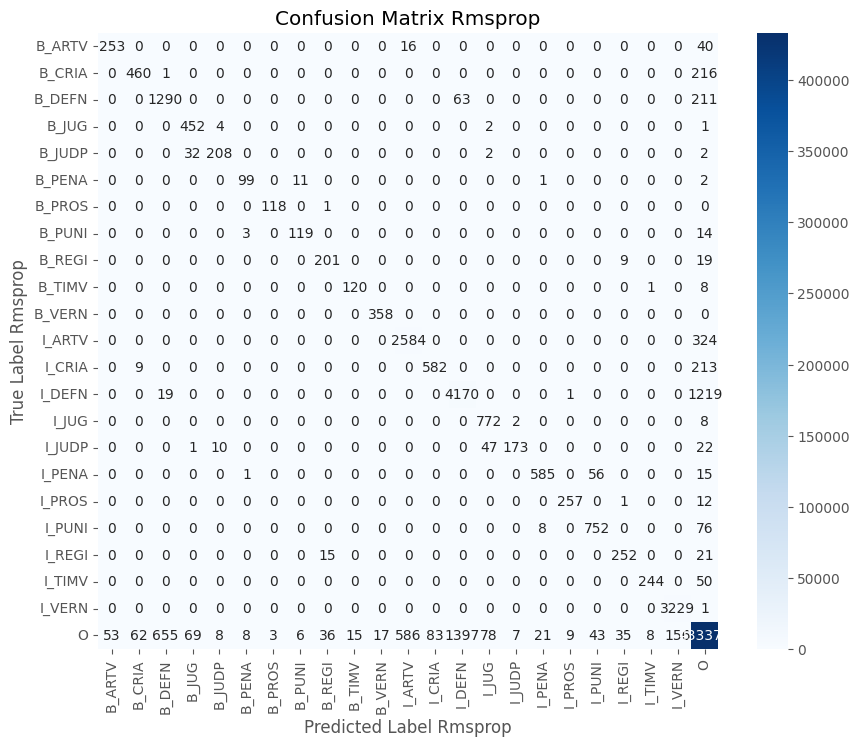

In [77]:
# Definisi class_names (sesuaikan dengan label yang sesuai dalam datasetmu)
class_names = ['B_ARTV', 'B_CRIA', 'B_DEFN', 'B_JUG', 'B_JUDP', 'B_PENA', 'B_PROS', 'B_PUNI', 'B_REGI', 'B_TIMV', 'B_VERN', 'I_ARTV', 'I_CRIA', 'I_DEFN', 'I_JUG', 'I_JUDP', 'I_PENA', 'I_PROS', 'I_PUNI', 'I_REGI', 'I_TIMV', 'I_VERN', 'O']

conf_matRmsprop = confusion_matrix([item for sublist in y_test_trueRmsprop for item in sublist],
                            [item for sublist in y_predRmsprop for item in sublist],
                            labels=class_names)
# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matRmsprop, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Rmsprop")
plt.xlabel("Predicted Label Rmsprop")
plt.ylabel("True Label Rmsprop")
plt.show()


## Prediksi Kalimat Baru

In [54]:
from pypdf import PdfReader
import re

def pdf_to_text(file_path):
    text = ""
    reader = PdfReader(file_path)
    for page in reader.pages:
        text += page.extract_text()
    return text

def preprocess_text(text):
    text = text.replace("Mahkamah Agung Republik Indonesia\nMahkamah Agung Republik Indonesia\nMahkamah Agung Republik Indonesia\nMahkamah Agung Republik Indonesia\nMahkamah Agung Republik Indonesia\nDirektori Putusan Mahkamah Agung Republik Indonesia\nputusan.mahkamahagung.go.id\n", "")
    text = text.replace("\nDisclaimer\nKepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\npelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\nDalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\nEmail : kepaniteraan@mahkamahagung.go.id", "")
    text = text.replace('P U T U S A N', 'PUTUSAN').replace('T erdakwa', 'Terdakwa').replace('T empat', 'Tempat').replace('T ahun', 'Tahun')
    text = text.replace('P  E  N  E  T  A  P  A  N', 'PENETAPAN').replace('J u m l a h', 'Jumlah').replace('M E N G A D I L I', 'MENGADILI')
    text = re.sub(r'(Hal\.\s*\S+(?:\s*\S+)?\.?\s*)|(Halaman \d+(?:\.\d+)?\s*)|Putusan Nomor \S+\s*', '', text)
    text = re.sub(r'\b0+(\d+)', r'\1', text)
    text = text.replace('\uf0d8', '').replace('\uf0b7', '').replace('\n', ' ')
    text = re.sub(r'([“”"])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'halaman\s*\d+\s*dari\s*\d+\s*', '', text)
    text = re.sub(r'^\s*dari\s+\d+\s+bkl\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^\s*dari\s+\d+\s+smp\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+/PN', '/PN', text)
    text = re.sub(r'(\d+)\s*/pid', r'\1/pid', text)
    text = re.sub(r'(?i)(nomor)(\d+)', r'\1 \2', text)
    text = re.sub(r'(\d+)/\s*(pid\.\w+)/\s*(\d{4})/\s*(pn)', r'\1/\2/\3/\4', text, flags=re.IGNORECASE)
    return text.lower().strip()

def multiple_replace(text, replacements):
    regex = re.compile('|'.join(re.escape(key) for key in replacements.keys()))

    def replace(match):
        return replacements[match.group(0)]

    return regex.sub(replace, text)

def tokenize_text(text):
    tokens = re.findall(r'\w+|[^\w\s]', text)
    return tokens



In [55]:
replacements = {
    '1 0': '10' ,'20 20': '2020', '2 7' : '27', 'a gustus' : 'agustus', '( 2)': '(2)', '.,': ' .,', ',s': ' ,s','ted dy' : 'teddy',
    'ro omius,' : 'roomius,', 'h ukum': 'hukum', '//pn': '/pn', '2022oleh' : '2022 oleh', 'alimuddi n,' : 'alimuddin,', '202 3': '2023',
    'perkos aan': 'perkosaan', 'memberatka n': 'memberatkan', 'p idana': 'pidana', 'sebag aimana': 'sebagaimana', 'bulan;' : 'bulan', '2 23' : '2023',
    '2 023': '2023','2 022': '2022', 'f isik': 'fisik', 'be rsalah': 'bersalah', '(sepuluh )': '(sepuluh)', 'ap ril' : 'april',
    '(enam )': '(enam)', 'no mor': 'nomor', '( 3)': '(3)', 'an ak': 'anak', 'tuj uh': 'tujuh', 'hu bungan': 'hubungan', 'pencur ian' : 'pencurian',
    'selam a1 (satu)' : 'selama 1 (satu)', '(empat )' : '(empat)', 's eptember' : 'september', 'keadaa n' : 'keadaan', '27januari' : '27 januari',
    'bulan;3.menetapkan' : 'bulan 3.menetapkan','januari,2023' : 'januari 2023', '202 2' : '2022','202 4' : '2024', '202 3' : '2023','2023//' : '2023',
    '20 22' : '2022','20 21' : '2021','202 1' : '2021', '27januari' : '27 januari', 'januari,2023' : 'januari 2023', 'sepember' : 'september',
    'bk l' : 'bkl','pm k' : 'pmk', 'bki' : 'bkl',  'pid.b /' : 'pid.b/', 'pn.' : 'pn ', 'pid. b' : 'pid.b', 'pnpmk' : 'pn pmk', '2023pn' : '2023 pn',
    'smp.' : 'smp', '(al m)' : '(alm)', 'Al m' : 'Alm', "'" : '’', 'b in' : 'bin', 'bu lan' : 'bulan', 'kuhpdan' : 'kuhp dan',
    'pencuriandalam' : 'pencurian dalam', 'keadaa n' : 'keadaan', 'pembunuhanberencana' : 'pembunuhan berencana', 'bulan3.menetapkan' : 'bulan 3.menetapkan',
    'bulan3.menyatakan' :  'bulan 3.menyatakan', 't aufik' : 'taufik', 'olehhaidir' : 'oleh haidir','olehfajrini' : 'oleh fajrini', 'janurai' : 'januari',
    'nopember': 'november','pebruari': 'februari','a gustus' : 'agustus', 'september2023,' : 'september 2023,','aapril' : 'april', 'ja nuari' : 'januari',
    'no mor': 'nomor', ',serta' : ', serta', 'agussyamsul' : 'agus syamsul', 'a stuti' : 'astuti'
}

In [56]:
pdf_path = '../Data/Test/7_Pid.B_2023_PN_Bkl.pdf'
text = pdf_to_text(pdf_path)
preprocessed_text = preprocess_text(text)
preprocessed_text = multiple_replace(preprocessed_text, replacements)
tokens = tokenize_text(preprocessed_text)

In [57]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
# from nltk.tokenize import word_tokenize
# def predict_labels(model, sentence, target_tags):
#     # Memisahkan kalimat menjadi beberapa kalimat berdasarkan tanda ';'
#     sentences = sentence.split(';')
#     all_sentence_results = []

#     for sent in sentences:
# #         words = split_token(sent)
# #         Tokenisasi kalimat menjadi kata-kata
#         words = sent.strip().split()
#         words = [re.split(r'(\W)', word) for word in words]
#         words = [item for sublist in words for item in sublist if item.strip()]
#         # Mendapatkan embedding kata dari model
#         embeddings = [get_word_embedding(word) for word in words]
#         # Padding sequence jika panjang kurang dari MAX_LEN
#         padded_sequence = pad_sequences([embeddings], maxlen=MAX_LEN, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))
# #         padded_sequence = np.array(padded_sequence)
#         # Melakukan prediksi dengan model
#         predictions = model.predict(padded_sequence)
#         # Mengambil indeks label terbesar untuk setiap kata
#         predicted_labels = np.argmax(predictions, axis=-1)[0]
#         # Mengubah indeks label menjadi tag kata
#         predicted_tags = [idx2tag[idx] for idx in predicted_labels]
# #         print(words)
# #         print(predicted_tags)
#         # Menyimpan hasil untuk setiap tag yang ditemukan dalam satu kalimat
#         temp_results = {key: [] for key in target_tags}

#         # Memetakan kata-kata berdasarkan prediksi tag
#         for word, tag in zip(words, predicted_tags):
#             for key, tags in target_tags.items():
#                 if tag in tags:
#                     temp_results[key].append(word)

#         # Menyatukan hasil dari kalimat ini ke dalam combined_results jika belum ada hasil untuk tag tersebut
#         for key in temp_results:
#             temp_results[key] = ' '.join(sorted(set(temp_results[key]), key=temp_results[key].index))
#         all_sentence_results.append(temp_results)
#         print(all_sentence_results)

#     return all_sentence_results

In [70]:
def predict_labels(model, sentence, target_tags):
    # Memisahkan kalimat menjadi beberapa kalimat berdasarkan tanda ';'
    sentences = sentence.split(';')

    # Inisialisasi dictionary hasil dengan semua target tags
    combined_results = {key: "" for key in target_tags}
    found_terdakwa = []
    tags_from_start = ["nomor putusan","nama terdakwa",  "melanggar UU", "putusan hukuman", "tuntutan hukuman"]
    # Daftar tag yang diambil dari akhir ke awal
    tags_from_end = ["jenis dakwaan","tanggal putusan", "hakim ketua", "hakim anggota", "penuntut umum", "panitera"]


    for sent in sentences:
        # Tokenisasi kalimat menjadi kata-kata
        words = sent.strip().split()
        words = [re.split(r'(\W)', word) for word in words]
        words = [item for sublist in words for item in sublist if item.strip()]

        # Mendapatkan embedding kata dari model
        embeddings = [get_word_embedding(word) for word in words]

        # Padding sequence jika panjang kurang dari MAX_LEN
        padded_sequence = pad_sequences([embeddings], maxlen=MAX_LEN, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))

        # Melakukan prediksi dengan model
        predictions = model.predict(padded_sequence)

        # Mengambil indeks label terbesar untuk setiap kata
        predicted_labels = np.argmax(predictions, axis=-1)[0]

        # Mengubah indeks label menjadi tag kata
        predicted_tags = [idx2tag[idx] for idx in predicted_labels]
#         print(words)
#         print(predicted_tags)

        # Menyimpan hasil untuk setiap tag yang ditemukan dalam satu kalimat
        temp_results = {key: [] for key in target_tags}

        # Memetakan kata-kata berdasarkan prediksi tag
        for word, tag in zip(words, predicted_tags):
            for key, tags in target_tags.items():
                if tag in tags:
                    temp_results[key].append(word)

        for key in temp_results:
            if key in tags_from_start and not combined_results[key] and temp_results[key]:
                combined_results[key] = ' '.join(sorted(set(temp_results[key]), key=temp_results[key].index))


# Mengambil entitas dari kalimat akhir ke awal
    for sent in reversed(sentences):
        if all(combined_results[key] for key in tags_from_end):
            break
        # Tokenisasi kalimat menjadi kata-kata
        words = sent.strip().split()
        words = [re.split(r'(\W)', word) for word in words]
        words = [item for sublist in words for item in sublist if item.strip()]

        # Mendapatkan embedding kata dari model
        embeddings = [get_word_embedding(word) for word in words]

        # Padding sequence jika panjang kurang dari MAX_LEN
        padded_sequence = pad_sequences([embeddings], maxlen=MAX_LEN, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))

        # Melakukan prediksi dengan model
        predictions = model.predict(padded_sequence)

        # Mengambil indeks label terbesar untuk setiap kata
        predicted_labels = np.argmax(predictions, axis=-1)[0]

        # Mengubah indeks label menjadi tag kata
        predicted_tags = [idx2tag[idx] for idx in predicted_labels]

        # Menyimpan hasil untuk setiap tag yang ditemukan dalam satu kalimat
        temp_results = {key: [] for key in target_tags}

        # Memetakan kata-kata berdasarkan prediksi tag
        for word, tag in zip(words, predicted_tags):
            for key, tags in target_tags.items():
                if tag in tags:
                    temp_results[key].append(word)

        # Menggabungkan hasil dari kalimat ini ke dalam combined_results jika belum ada hasil untuk tag tersebut
        for key in temp_results:
            if key in tags_from_end and not combined_results[key] and temp_results[key]:
                combined_results[key] = ' '.join(sorted(set(temp_results[key]), key=temp_results[key].index))
    if combined_results['hakim anggota']:
        combined_results['hakim anggota'] = process_hakim_anggota(combined_results['hakim anggota'])


    return combined_results

def process_hakim_anggota(text):
    # Find all sequences that match the pattern and combine them with 'dan'
    matches = re.findall(r'(\w+\s\w+)', text)
    if matches:
        return ' dan '.join(matches)
    return text

In [71]:
target_tags = {"nomor putusan": ["B_VERN", "I_VERN"], "nama terdakwa": ["B_DEFN", "I_DEFN"], "jenis dakwaan": ["B_CRIA", "I_CRIA"],
              "melanggar UU": ["B_ARTV", "I_ARTV"], "putusan hukuman": ["B_PUNI", "I_PUNI"], "tuntutan hukuman": ["B_PENA", "I_PENA"],
              "tanggal putusan": ["B_TIMV", "I_TIMV"], "hakim ketua": ["B_JUDP", "I_JUDP"], "hakim anggota": ["B_JUG", "I_JUG"],
              "penuntut umum": ["B_PROS", "I_PROS"], "panitera": ["B_REGI", "I_REGI"]}

### Prediksi SGD

In [72]:
relevant_wordsSGD = predict_labels(modelSGD, preprocessed_text,target_tags)

1/1 [==============================] - 0s 98ms/step


In [73]:
for key, words in relevant_wordsSGD.items():
    if words:
        if key.lower() == 'nomor putusan':
            output = words.replace(' / ', '/').replace(' ','').replace('pn','pn ').replace('.b','.b/').replace('2021','2021/').replace('2022','2022/').replace('2023','2023/').replace('2024','2024/')
        else:
            output = words.replace('“','').replace('”','')
        print(f"{key.capitalize()}: {output}")
    else:
        print(f"Tidak ada kata dengan tag {key} dalam kalimat ini.")

Nomor putusan: /pn bklnomor7pid.b/2023/
Nama terdakwa: bin
Tidak ada kata dengan tag jenis dakwaan dalam kalimat ini.
Melanggar uu: ayat
Putusan hukuman: ( satu ) tahun empat
Tidak ada kata dengan tag tuntutan hukuman dalam kalimat ini.
Tidak ada kata dengan tag tanggal putusan dalam kalimat ini.
Tidak ada kata dengan tag hakim ketua dalam kalimat ini.
Tidak ada kata dengan tag hakim anggota dalam kalimat ini.
Tidak ada kata dengan tag penuntut umum dalam kalimat ini.
Tidak ada kata dengan tag panitera dalam kalimat ini.


### Prediksi Adam

In [74]:
relevant_wordsAdam = predict_labels(modelAdam, preprocessed_text,target_tags)

1/1 [==============================] - 0s 83ms/step


In [75]:
for key, words in relevant_wordsAdam.items():
    if words:
        if key.lower() == 'nomor putusan':
            output = words.replace(' / ', '/').replace(' ','').replace('pn','pn ').replace('.b','.b/').replace('2021','2021/').replace('2022','2022/').replace('2023','2023/').replace('2024','2024/')
        else:
            output = words.replace('“','').replace('”','')
        print(f"{key.capitalize()}: {output}")
    else:
        print(f"Tidak ada kata dengan tag {key} dalam kalimat ini.")

Nomor putusan: 7/pid.b/2023/pn bkl
Nama terdakwa: rizal kurniawan bin jatim
Jenis dakwaan:  pencurian dalam keadaan memberatkan
Melanggar uu: 363 ayat ( 1 ) ke - 5 kuhp
Putusan hukuman: ( satu )
Tuntutan hukuman: 1 ( satu ) tahun 4 empat bulan
Tanggal putusan: 9 maret 2023
Hakim ketua: putu wahyudi
Hakim anggota: satrio budiono dan wahyu eko
Penuntut umum: haidir rahman
Panitera: muhammad hamdi


### Prediksi Rmsprop

In [ ]:
relevant_wordsRmsprop = predict_labels(modelRmsprop, preprocessed_text,target_tags)

In [ ]:
for key, words in relevant_wordsRmsprop.items():
    if words:
        if key.lower() == 'nomor putusan':
            output = words.replace(' / ', '/').replace(' ','').replace('pn','pn ').replace('.b','.b/').replace('2021','2021/').replace('2022','2022/').replace('2023','2023/').replace('2024','2024/')
        else:
            output = words.replace('“','').replace('”','')
        print(f"{key.capitalize()}: {output}")
    else:
        print(f"Tidak ada kata dengan tag {key} dalam kalimat ini.")